In [10]:
import numpy as np
from sklearn import datasets
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import matplotlib.pyplot as plt







In [29]:
iris = datasets.load_iris()

# Load the Iris dataset
iris_data = datasets.load_iris()
X, y = iris_data.data, iris_data.target

# Apply stratified splitting to maintain class distribution in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=iris.target, random_state=42)

print('y_test:',y_test)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)



y_test: [0 2 1 1 0 1 0 0 2 1 2 2 2 1 0 0 0 1 1 2 0 2 1 2 2 1 1 0 2 0]
X_train: (120, 4)
y_train: (120,)
X_test: (30, 4)
y_test: (30,)


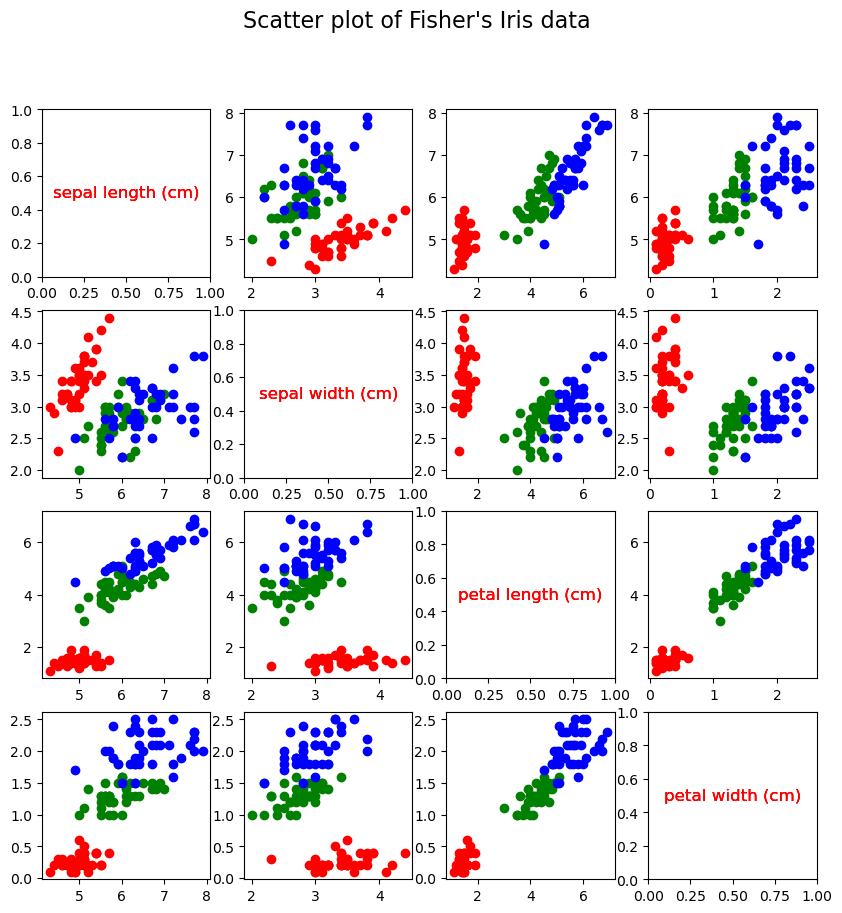

In [18]:


def plt_scatter(X_train: np.array, y_train: np.array):
    """
    Scatter plot of Fisher's Iris data
    """
    fig, ax = plt.subplots(4, 4, figsize=(10, 10))
    
    i = 0
    while i < 4:
        j = 0
        while j < 4:
            if i == j:
                for target in np.unique(y_train):
                    ax[i, j].text(0.5, 0.5, iris.feature_names[i],
                                 horizontalalignment='center',
                                 verticalalignment='center',
                                 fontsize=12, color='red',
                                 transform=ax[i, j].transAxes)
            else:
                colors = ['red', 'green', 'blue']
                for idx, target in enumerate(np.unique(y_train)):
                    ax[i, j].scatter(X_train[y_train == target, j],
                                     X_train[y_train == target, i],
                                     alpha=1.0, color=colors[idx])
            j += 1
        i += 1
    
    # title
    plt.suptitle("Scatter plot of Fisher's Iris data", fontsize=16)
                    
    plt.show()

plt_scatter(X_train, y_train)


In [19]:
def likelihood(X, mean, std):
    """
    Calculate the likelihood of the data given the mean and standard deviation
    likelihood = P(X|y) = P(x1|y) * P(x2|y) * P(x3|y) * P(x4|y)
    """
    # Calculate likelihood using norm.pdf() and taking the product of all likelihoods for all features.
    return np.prod(norm.pdf(X, loc=mean, scale=std))

def mean_std(X_train, Y_train, n_classes=3):
    """
    Calculate the mean and standard deviation for each feature in each category
    """
    # Initialize arrays for mean and standard deviation
    mean = np.zeros((n_classes, X_train.shape[1]))
    std = np.zeros((n_classes, X_train.shape[1]))

    category = 0
    while category < n_classes:
        feature = 0
        while feature < X_train.shape[1]:
            X_cat = X_train[Y_train == category]
            mean[category, feature] = np.mean(X_cat[:, feature])
            std[category, feature] = np.std(X_cat[:, feature])
            feature += 1
        category += 1

    return mean, std



In [30]:
def prior_probs(Y_train):
    """
    Calculate the prior probability of each category
    prior = P(y)
    return: the probability of each category
    """
    # Calculate the counts of each category
    counts = np.bincount(Y_train)
    
    # Calculate the total number of samples
    total_samples = len(Y_train)
    
    # Calculate the prior probability of each category
    probabilities = counts / total_samples
    
    return probabilities
# Calculate prior probabilities
prior = prior_probs(Y_train)

# Print prior probabilities
for i, prob in enumerate(prior):
    print(f"Class {i}: Prior Probability = {prob:.2f}")


Class 0: Prior Probability = 0.33
Class 1: Prior Probability = 0.33
Class 2: Prior Probability = 0.33


In [34]:
def posterior_probs(X_train, X_test, Y_train, n_classes=3):
    """
    Calculate the posterior probabilities of each category for each sample
    posterior = P(y|x) = P(x|y) * P(y)
    """
    # Calculate mean and standard deviation for training data
    mean, std = mean_std(X_train, Y_train)
    
    # Initialize posterior probabilities
    posterior_probs_ = np.zeros((len(X_test), n_classes))
    
    # Initialize index
    i = 0
    while i < len(X_test):
        category = 0
        while category < n_classes:
            # Calculate likelihood
            likelihood_ = likelihood(X_test[i], mean[category], std[category])
            # Calculate posterior probability
            posterior_probs_[i, category] = likelihood_ * prior_probs(Y_train)[category]
            category += 1
        i += 1
    
    # Normalize posterior probabilities
    sum_posterior = np.sum(posterior_probs_, axis=1, keepdims=True)
    i = 0
    while i < len(X_test):
        posterior_probs_[i] /= sum_posterior[i]
        i += 1
    
    return posterior_probs_




In [38]:
def naive_bayes(X_train, Y_train):
    """
    a Naive Bayes classifier without using similar methods.
    """
    n_classes = len(np.unique(Y_train))
    n_features = X_train.shape[1]

    class_mean = np.zeros((n_classes, n_features))
    class_std = np.zeros((n_classes, n_features))
    class_prior = np.zeros(n_classes)

    # Calculate class prior probabilities
    c = 0
    while c < n_classes:
        class_prior[c] = np.sum(Y_train == c) / len(Y_train)
        c += 1

    # Calculate class mean and standard deviation
    c = 0
    while c < n_classes:
        X_c = X_train[Y_train == c]
        class_mean[c] = np.mean(X_c, axis=0)
        class_std[c] = np.std(X_c, axis=0)
        c += 1

    #print(class_mean, class_std, class_prior)
    return class_mean, class_std, class_prior

def predict(X_test, class_mean, class_std, class_prior):
    """
    Predict the class labels for test samples.
    """
    n_samples = X_test.shape[0]
    n_classes = len(class_prior)
    predictions = np.zeros(n_samples, dtype=int)

    i = 0
    while i < n_samples:
        posteriors = []
        c = 0
        while c < n_classes:
            likelihood = np.prod(norm.pdf(X_test[i], class_mean[c], class_std[c]))
            posterior = likelihood * class_prior[c]
            posteriors.append(posterior)
            c += 1
        predictions[i] = np.argmax(posteriors)
        i += 1

    return predictions

# Load Iris dataset
iris = datasets.load_iris()
X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.2, stratify=iris.target, random_state=42)

# Fit Naive Bayes classifier
class_mean, class_std, class_prior = naive_bayes(X_train, Y_train)

# Predict
predictions = predict(X_test, class_mean, class_std, class_prior)

# Evaluation (calculate accuracy)
# Calculate accuracy percentage
accuracy = np.mean(predictions == Y_test)




In [25]:
# Calculate accuracy percentage
accuracy_percentage = accuracy 
print("Accuracy:", accuracy_percentage)

Accuracy: 0.9666666666666667


In [37]:
# Print the output
print("Class Mean:")
print(class_mean)
print("\nClass Standard Deviation:")
print(class_std)
print("\nClass Prior Probability:")
print(class_prior)

Class Mean:
[[4.985  3.415  1.4775 0.255 ]
 [5.93   2.75   4.2525 1.32  ]
 [6.61   2.98   5.58   2.04  ]]

Class Standard Deviation:
[[0.30458989 0.39404949 0.15888282 0.11390786]
 [0.47074409 0.30495901 0.43759999 0.18466185]
 [0.67631354 0.3494281  0.56885851 0.26532998]]

Class Prior Probability:
[0.33333333 0.33333333 0.33333333]
